# Seguimento de trajetórias para um robô móvel tipo carro

# 1. Introdução


*   Baseia-se no projeto de técnicas de controle que desejam posicionar o veículo sobre um caminho previamente determinado
*   Modelos puramente cinemáticos são os mais utilizados

*   Devido a trajetórias em baixas velocidades, a inércia do veículo é desprezível 
*   Lei de controle de direção para o seguimento de trajetória 
*   Entradas as variáveis de estado do veículo e o caminho planejado
*   Saída o ângulo de esterçamento do veículo e a velocidade constante

# 2. Pybullet 

* Módulo Python para simulação física
* Robótica
* Jogos
* Efeitos visuais 
* Aprendizagem de Máquina
* Foco em transferência da simulação para o robô real
* O ambiente permite uma variedade de simulações 
* Dinâmica 
* Cinemáticas direta e inversa
* Detecção de colisão

Link: https://pybullet.org/wordpress/

## 2.1 Utilizando o Pybullet

* Python 
* Instalar o pacote (Windows e Linux)

### 2.1.1 Pacotes

In [1]:
# Pacotes
import pybullet as p
import time 
import pybullet_data
from math import pi
import math
from os.path import dirname, join as pjoin
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import random
import os 

### 2.1.2 Interface

In [2]:
p.connect(p.GUI)

0

## 2.1.3 Resete

In [5]:
p.resetSimulation()

#### 2.1.5.3 Racecar

In [51]:
# ================ Plano e Ambiente ================ #
p.resetSimulation() # Reset
p.setAdditionalSearchPath(pybullet_data.getDataPath()) # Referência dos arquivos URDF
plane = p.loadURDF("plane.urdf") # Adiciona um plano
p.setGravity(0, 0, -9.81) # Gravidade (x,y,z)
step = 0.0001 # Intervalo da simulação 
p.setTimeStep(step) # time step
p.setRealTimeSimulation(0) # Retorna o tempo em zero

# ================ Robô ================ #
carro1 = p.loadURDF("racecar/racecar.urdf",[0, 0, 0.001],useFixedBase=0) # Posição
carro2 = p.loadURDF("racecar/racecar.urdf",[0, -0.90, 0.001],useFixedBase=0) # Posição

# 3. Modelagem

* Puramente Cinemática

* Para baixas velocidades a dinâmica pode ser desprezada

##### Cinemática

* Descreve o movimento de um corpo, mas não se preocupa com as suas causas

##### Cinemática Direta

* A partir das posições das articulações, encontrar a posição e orientação da ferramenta no espaço cartesiano da base

##### Cinemática Inversa

* Definir as posições das articulações, dada uma posição e orientação desejada para a ferramenta 
 

In [4]:
# Dados do veículo:
rr = 0.05 # Raio da roda
D = 0.2 # Distância entre as rodas do mesmo eixo
L = 0.325 # Distância entre eixos 
B = 290/1000
f = 100/1000
l =  50/1000
A = l + f + L
phi_max = pi/6 # Ângulo de esterçamento máximo do veículo
dphi = 1 # Velocidade máxima do ângulo de esterçamento
# https://github.com/bulletphysics/bullet3/blob/master/data/racecar/racecar.urdf

### 3.1.1 Exemplo

$\phi = \frac{\pi}{8}$

$ R = \frac{L}{\tan{(\phi)}} = \frac{0.325}{0.41421356237309503} = 0.7846194077712559 $

$V = 1 $ m/s

$\dot \theta = \frac{V}{R}$

#### Condições Iniciais

$x_0 = 0 $

$y_0 = 0 $

$\theta_0 = 0 $

#### 3.1.1.1 Teórico

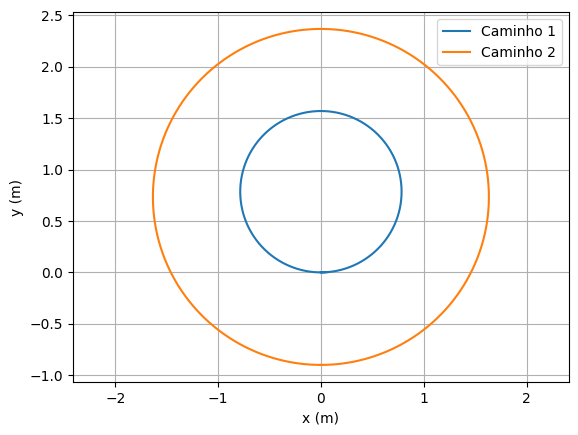

In [5]:
V = 1 # Velocidade 
R1 = L/math.tan(pi/8) # Raio de curvatura
R2 = L/math.tan(pi/16) # Raio de curvatura

dtheta1 = V/R1  # Velocidade ângular
dtheta2 = V/R2  # Velocidade ângular 
step = 0.0001 # Intervalo da simulação  

# Condições iniciais carro 1:
x1  = [0]
y1  = [0]
th1 = [0]

# Condições iniciais carro 2:
x2  = [0]
y2  = [-0.9]
th2 = [0]

# Tempo discreto
for i in range(50000):
    th1.append(th1[i] + dtheta1*step) # theta[i]
    dx1 = V*math.cos(th1[i])         # dx[i]
    dy1 = V*math.sin(th1[i])         # dy[i]
    x1.append(x1[i] + dx1*step)       # x[i]
    y1.append(y1[i] + dy1*step)       # y[i]


# T = (2*pi*R2)/V
for j in range(102700):
    th2.append(th2[j] + dtheta2*step) # theta[i]
    dx2 = V*math.cos(th2[j])         # dx[i]
    dy2 = V*math.sin(th2[j])         # dy[i]
    x2.append(x2[j] + dx2*step)       # x[i]
    y2.append(y2[j] + dy2*step)       # y[i]



# Gráfico
plt.plot(x1, y1, '-', label='Caminho 1')
plt.plot(x2, y2, '-', label='Caminho 2')
plt.axis('equal')
plt.legend(loc = 'upper right')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.show()

#### 3.1.1.2 Simulação

In [6]:
def geometria_ackermann (model, V, phi, D, L, r, phi_max, dphi):
    # Função que define a velocidade e o ângulo de esterçamento de cada roda 
    # V = velocidade linear do veículo referenciando o modelo do tipo bicicleta, entre eixos traseiro;
    # phi = Ângulo de esterçamento da roda dianteira imaginária central;
    # D = Distância entre as rodas do mesmo eixo;
    # L = Distrância entre os eixos
    # r = Raio da roda do veículo
    # phi_max = Ângulo de esterçamento máximo
    # dphi = Velocidade do ângulo de esterçamento
    
    # Limite do ângulo de esterçamento
    if abs(phi) > phi_max:
        phi = phi/(abs(phi))*phi_max 
    
    # Converter a velocidade V para rad/s
    V = V/r # rad/s
    if phi == 0:
        R = 99999999
    else:
        R = L/(math.tan(phi))
    phi_1 = math.atan(L/(R+D/2)) # Roda da direita
    phi_2 = math.atan(L/(R-D/2)) # Roda da esquerda
    vtd = V*(1+D/(2*R)) # 3
    vte = V*(1-D/(2*R)) # 2
    vfd = vtd/(math.cos(phi_1)) # 7
    vfe = vte/(math.cos(phi_2)) # 5
    
    
    # Torque
    T = 1
    
    
    # Velocidade
    # vfd
    p.setJointMotorControl2(model,7,p.VELOCITY_CONTROL,force=T,targetVelocity=vfd)

    # vfe
    p.setJointMotorControl2(model,5,p.VELOCITY_CONTROL,force=T,targetVelocity=vfe)

    # vtd
    p.setJointMotorControl2(model,3,p.VELOCITY_CONTROL,force=T,targetVelocity=vtd)

    # vte
    p.setJointMotorControl2(model,2,p.VELOCITY_CONTROL,force=T,targetVelocity=vte)
    
    # Ângulo de esterçamento
    # phi_1
    p.setJointMotorControl2(model,6, p.POSITION_CONTROL,maxVelocity=dphi,targetPosition = phi_1)
    # phi_2
    p.setJointMotorControl2(model,4, p.POSITION_CONTROL,maxVelocity=dphi,targetPosition = phi_2)

# 4. Controle 

*   Baseia-se no projeto de técnicas de controle que desejam posicionar o veículo sobre um caminho previamente determinado
*   Modelos puramente cinemáticos são os mais utilizados

*   Devido a trajetórias em baixas velocidades, a inércia do veículo é desprezível 
*   Lei de controle de direção para o seguimento de trajetória 
*   Entradas as variáveis de estado do veículo e o caminho planejado
*   Saída o ângulo de esterçamento do veículo e a velocidade constante

In [7]:
def perseguição_pura(model, L ,xf, yf):
    '''
    CONTROLE POR PERSEGUIÇÃO PURA PARA um PONTO (xf,yf)
    model = modelo do veículo;
    xf,yf = Ponto final desejada;
    Vv = Velocidade para o veículo (saída);
    Phiv = Ângulo de esterçamento do veículo (saída); 
    L = Distância entre eixos do veículo
    '''
    # Posição e pose do veículo
    world_position, world_orientation = p.getLinkState(model, 0)[:2]
    w = world_orientation[3]
    # Pose do veículo
    thv = math.acos(w)*2 
    if world_orientation[2] != 0:
        thv = thv*world_orientation[2]/(abs(world_orientation[2]))
    # Posição do veículo
    xv = world_position[0] # Posição x do veículo
    yv = world_position[1] # Posição y do veículo
    
    # Dados entre o veículo (xv,yv,thv) e o ponto de referência (xf,yf)
    ld = ((xf-xv)**2 + (yf-yv)**2)**(1/2) # Distância entre o veículo e ponto de referência 
    
    # Alpha
    xf = xf - xv
    yf = yf - yv
    xf2 = xf*math.cos(thv) + yf*math.sin(thv)  
    if xf2 == 0: # Não pode dividir por zero
        xf2 = 0.0000000001
    yf2 = -xf*math.sin(thv) + yf*math.cos(thv)
    a = math.atan2(yf2,xf2)
    
    # Normalizar a 
    if a < -pi:
        a = pi + 2*math.pi
    if a > pi:
        a = pi - 2*math.pi
    
    # Ângulo de esterçamento
    phiv = math.atan2(2*L*math.sin(a),ld)
    
    return phiv  

### 4.1.1 Exemplo

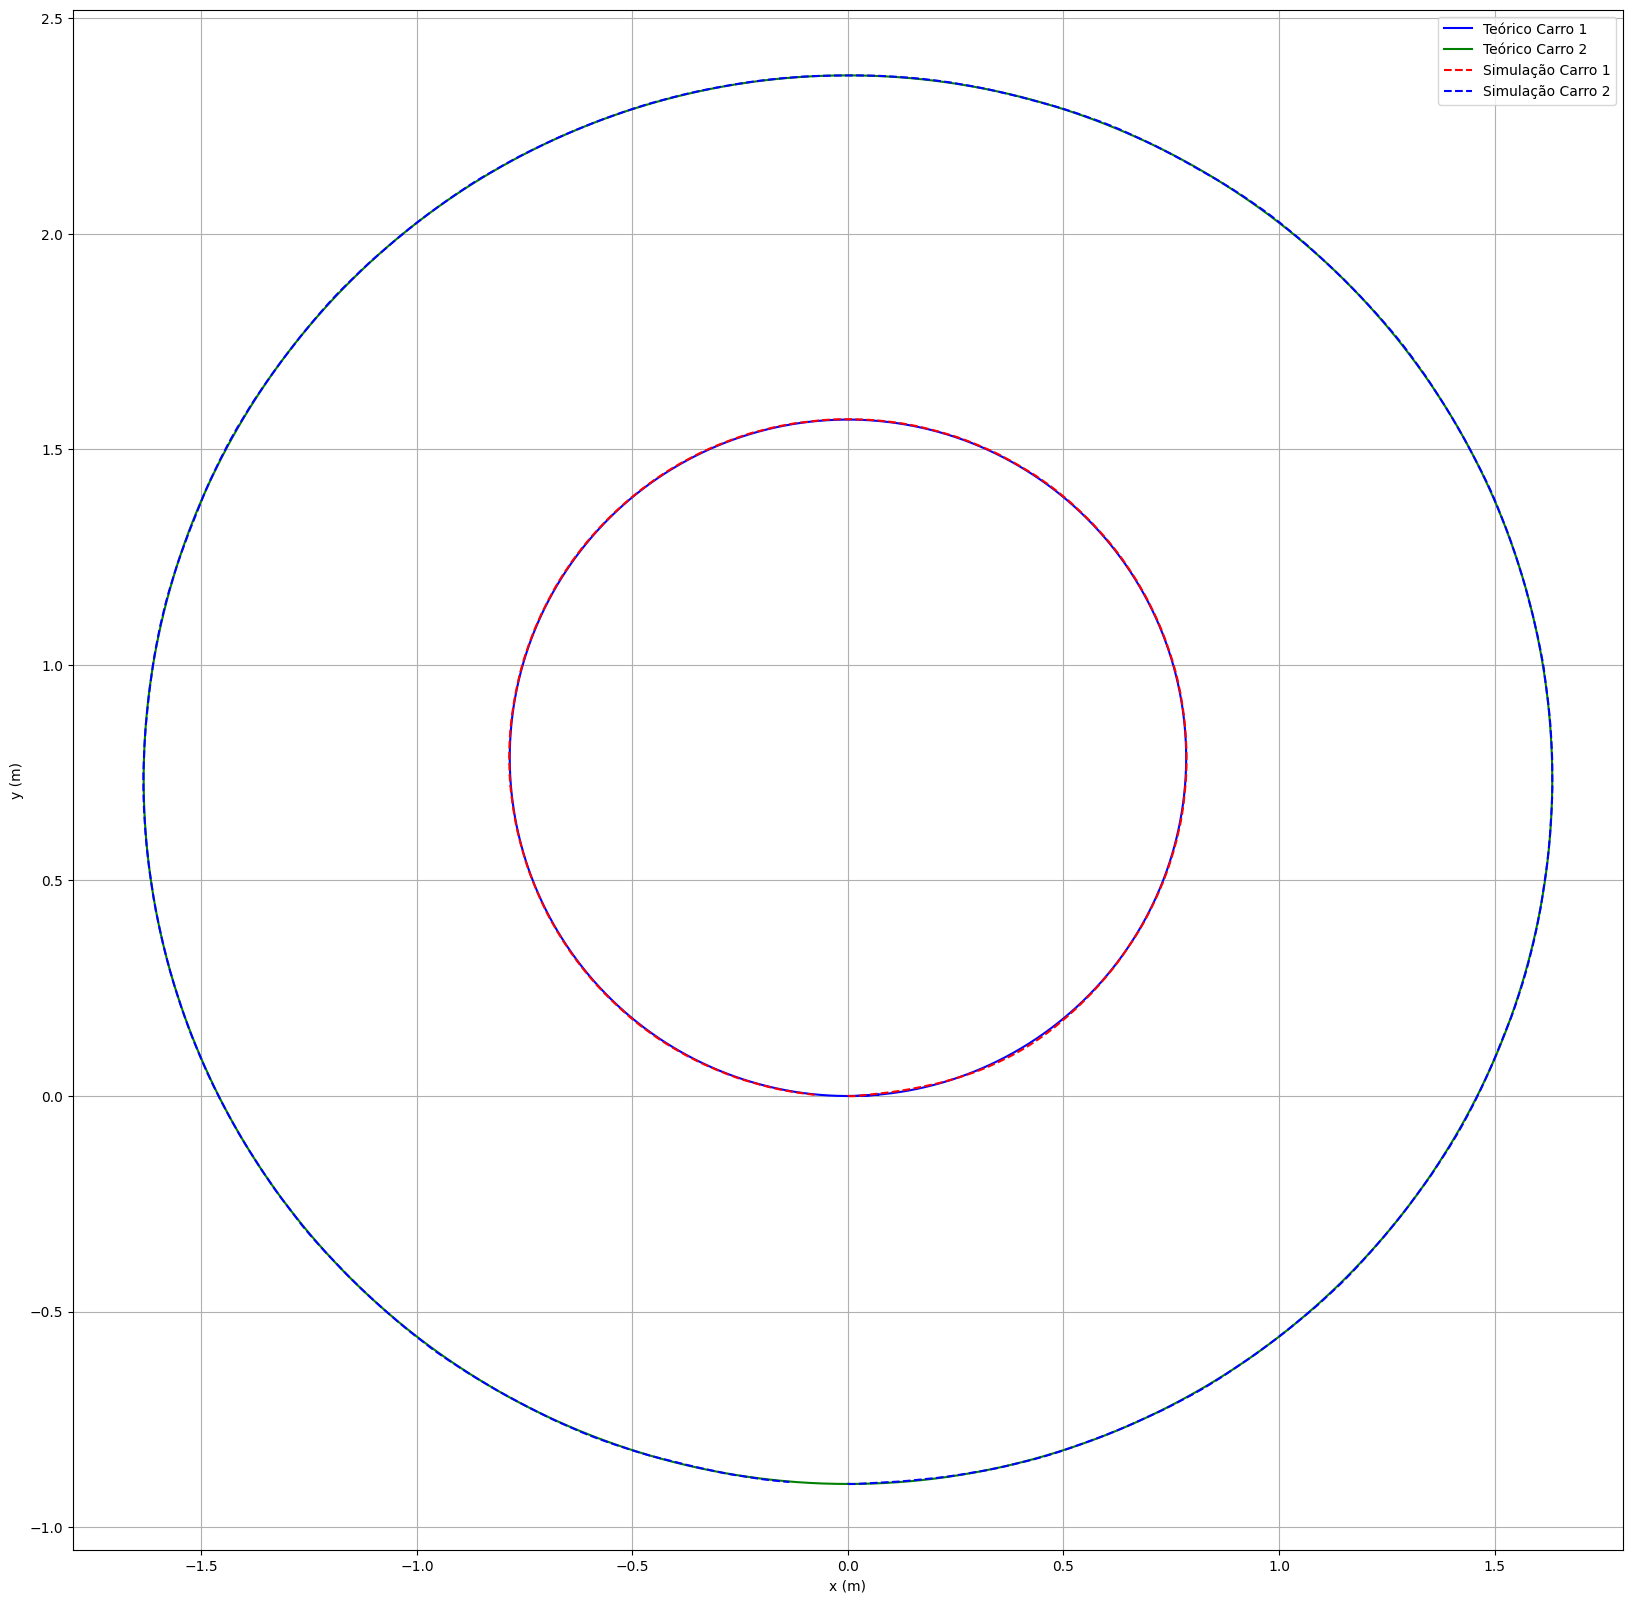

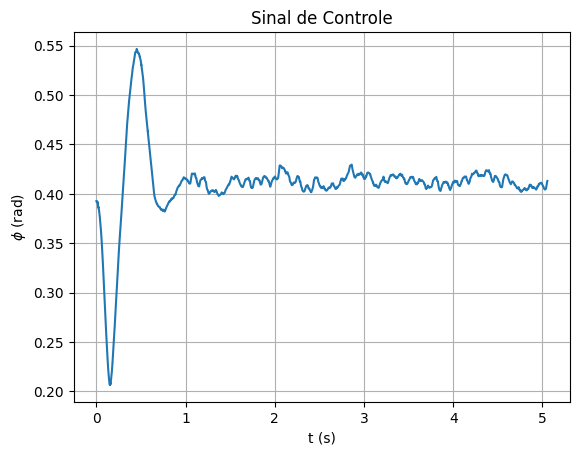

In [11]:
# ================ Plano e Ambiente ================ #
p.resetSimulation() # Reset
p.setAdditionalSearchPath(pybullet_data.getDataPath()) # Referência dos arquivos URDF
plane = p.loadURDF("plane.urdf") # Adiciona um plano
p.setGravity(0, 0, -9.81) # Gravidade (x,y,z)
step = 0.0001 # Intervalo da simulação 
p.setTimeStep(step) # time step
p.setRealTimeSimulation(0) # Retorna o tempo em zero

# ================ Robô ================ #
carro1 = p.loadURDF("racecar/racecar.urdf",[0, 0, 0.01],useFixedBase=0) # Posição
carro2 = p.loadURDF("racecar/racecar.urdf",[0, -0.9, 0.01],useFixedBase=0) # Posição

# Condições iniciais
position1, orientation1 = p.getLinkState(carro1, 0)[:2] # Dados espaciais da referência

position2, orientation2 = p.getLinkState(carro2, 0)[:2] # Dados espaciais da referência

xvp1 = [position1[0]]
yvp1 = [position1[1]]
phiv1 = [pi/8]

xvp2 = [position2[0]]
yvp2 = [position2[1]]
phiv2 = [pi/16]

# Ângulo de esterçamento
geometria_ackermann (carro1, 0, pi/8, D, L, rr, phi_max, dphi)
geometria_ackermann (carro2, 0, pi/16, D, L, rr, phi_max, dphi)

for _ in range(10000):
    p.stepSimulation() 

Lda = 0.14
for i in range(50000):
    xf1 = x1[i] # Referência em x
    yf1 = y1[i] # Referência em y
    position1, orientation1 = p.getLinkState(carro1, 0)[:2] # Dados espaciais da referência
    D1 = ((position1[0] - xf1)**2 + (position1[1] - yf1)**2)**(1/2) # Mede a distância entre o veículo e o ponto de referência
    while D1 > Lda: # Equanto a distância mínima não for alcançada, segue-se com o mesmo referencial
        phic1 = perseguição_pura(carro1, L, xf1, yf1) # Controle de perseguição pura 
        geometria_ackermann (carro1, V, phic1, D1, L, rr, phi_max, dphi) # Modelo geometria ackermann 
        #modelo_bicicleta (carro, V, phic, D, L, rr, phi_max, dphi) # Modelo tipo bicicleta 
        phiv1.append(phic1)
        p.stepSimulation()
        position1, orientation1 = p.getLinkState(carro1, 0)[:2] # Dados espaciais da referência
        xvp1.append(position1[0])
        yvp1.append(position1[1])
        D1 = ((position1[0] - xf1)**2 + (position1[1] - yf1)**2)**(1/2)

for i in range(102700):
    xf2 = x2[i] # Referência em x
    yf2 = y2[i] # Referência em y
    position2, orientation2 = p.getLinkState(carro2, 0)[:2] # Dados espaciais da referência
    D2 = ((position2[0] - xf2)**2 + (position2[1] - yf2)**2)**(1/2) # Mede a distância entre o veículo e o ponto de referência
    while D2 > Lda: # Equanto a distância mínima não for alcançada, segue-se com o mesmo referencial
        phic2 = perseguição_pura(carro2, L, xf2, yf2) # Controle de perseguição pura 
        geometria_ackermann (carro2, V, phic2, D2, L, rr, phi_max, dphi) # Modelo geometria ackermann 
        #modelo_bicicleta (carro, V, phic, D, L, rr, phi_max, dphi) # Modelo tipo bicicleta 
        phiv2.append(phic2)
        p.stepSimulation()
        position2, orientation2 = p.getLinkState(carro2, 0)[:2] # Dados espaciais da referência
        xvp2.append(position2[0])
        yvp2.append(position2[1])
        D2 = ((position2[0] - xf2)**2 + (position2[1] - yf2)**2)**(1/2)
        
# Gráfico
plt.figure(figsize=(20,20))
plt.plot(x1,y1, 'b-', label = 'Teórico Carro 1')
plt.plot(x2,y2, 'g-', label = 'Teórico Carro 2')
plt.plot(xvp1,yvp1, 'r--',label = 'Simulação Carro 1')
plt.plot(xvp2,yvp2, 'b--',label = 'Simulação Carro 2')
plt.axis('equal')
plt.legend(loc = 'upper right')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.show()

# Sinal de controle 
t = np.linspace(0,step*len(phiv1),len(phiv1))
plt.plot(t,phiv1)
plt.grid()
plt.xlabel('t (s)')
plt.ylabel('$\phi$ (rad)')
plt.title ('Sinal de Controle')
plt.show()

# 5 Conclusão

* Pybullet
* Modelo cinemático tipo bicicleta
* Geometria de Ackermann
* Controlador de perseguição pura
